# Ethics for NLP: Spring 2022
## Homework 1

In [21]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5
import gensim

from platform import python_version

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\ZhuoY\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


### Word Vectors

#### Count Based Word Vectors

In [7]:
def read_corpus(category="grain"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [8]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'china', 'daily', 'says', 'vermin', 'eat', '7', '-', '12', 'pct', 'grain', 'stocks',
  'a', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume',
  'between', 'seven', 'and', '12', 'pct', 'of', 'china', "'", 's', 'grain', 'stocks', ',', 'the',
  'china', 'daily', 'said', '.', 'it', 'also', 'said', 'that', 'each', 'year', '1', '.', '575',
  'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'china', "'", 's', 'fruit', 'output', 'are',
  'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30',
  'pct', ',', 'of', 'its', 'vegetables', '.', 'the', 'paper', 'blamed', 'the', 'waste', 'on',
  'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', '.', 'it', 'said', 'the',
  'government', 'had', 'launched', 'a', 'national', 'programme', 'to', 'reduce', 'waste', ',',
  'calling', 'for', 'improved', 'technology', 'in', 'storage', 'and', 'preservation', ',', 'and',
  'greater', 'production', 'of', 

#### Implement the function below

returned corpus_words should be sorted.

In [9]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    corpus_words=[word for sent in corpus for word in sent ]
    corpus_words=sorted(set(corpus_words))
    n_corpus_words=len(corpus_words)


    

    # ------------------

    return corpus_words, n_corpus_words

In [10]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


#### Implement compute_co_occurrence_matrix

In [11]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.
    M=np.zeros(shape=(n_words,n_words))
    for index, word in enumerate(words):
        word2ind[word]=index

    for sent in corpus:
        for index_sent,word in enumerate(sent):
            index_matrix=word2ind.get(word)
            if index_matrix != None:
                for i in range(1,window_size+1):
                    if index_sent+i<len(sent): # retrieve further words
                        index_nxtWord_matrix=word2ind.get(sent[index_sent+i])
                        if index_nxtWord_matrix!=None:
                            M[index_matrix][index_nxtWord_matrix]+=1
                    if index_sent-i>=0: # retrieve previous words
                        index_nxtWord_matrix=word2ind.get(sent[index_sent-i])
                        if index_nxtWord_matrix!=None:
                            M[index_matrix][index_nxtWord_matrix]+=1


    

    # ------------------

    return M, word2ind

In [12]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


#### Implement reduce_to_k_dim

In [13]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.

    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    M_reduced=svd.fit_transform(X=M)
    

    # ------------------

    print("Done.")
    return M_reduced

In [14]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


#### Implement plot_embeddings

In [32]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    
    words_matrix=[]
    
    for word in words:
        index=word2ind.get(word)
        if index!=None:
            words_matrix.append(M_reduced[index])
    
    
    for vector, word in zip(words_matrix, words):
        plt.scatter(vector[0],vector[1], marker='.', color='red')
        plt.text(vector[0], vector[1]-0.1, word, fontsize=9)
        
    
    plt.show()

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


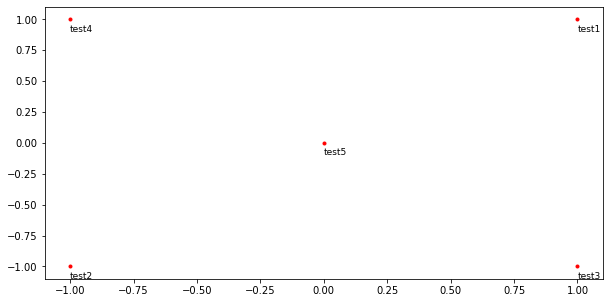

--------------------------------------------------------------------------------


In [33]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

#### Co-occurrence Plot Analysis

Running Truncated SVD over 7146 words...
Done.


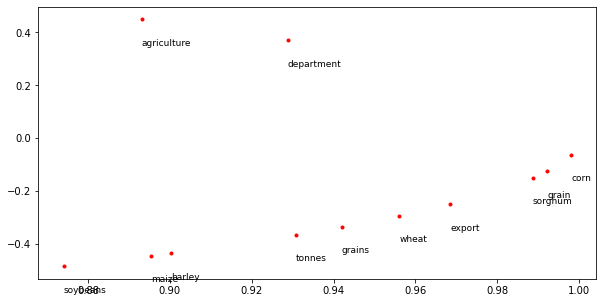

In [34]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words=['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']
# words =“吨”、“谷物”、“小麦”、“农业”、“玉米”、“玉米”、“出口”、“部门”、“大麦”、“谷物”、“大豆”、“高粱”

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

##### What clusters together in 2-dims embedding space?

MY ANSWER: It seems to have 4 clusters. 

- [soybeans, maiz, barley], [tonnes, grains, wheat, export], [sorghum, grain, corn], [department, agriculture]

#### What doesn't cluster together that you might think should have?

MY ANSWER: From my opinion, 'corn' and 'maize' should cluster together since the semantics of these words are same. In additional, 'barley', 'grains', 'soybeans', 'sorghum', 'grain', 'wheat' should also be clustered since they can categorized as argricultural products.

#### Prediction Based Word Vectors

In [23]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [24]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Reduce Embedding Dimension

In [25]:
def get_matrix_of_vectors(wv_from_bin, required_words=['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [26]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


#### GloVe Plot Analysis

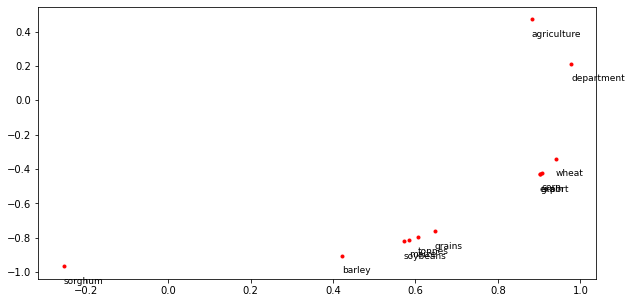

In [36]:
words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']
plot_embeddings(M_reduced_normalized, word2ind, words)

##### What clusters together in 2 dimensional embedding space?

MY ANSWER: 
['soybeans', 'tonnes' , 'maize', 'grains'], 
['wheat','corn','export'],
['sorghum'],['barley'],['argriculture'],['department']

##### What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

MY ANSWER:

- I think 'barley', 'sorghum' could be clustered together. 
- The difference between the plot 1 (generated from the co-occurrence matrix) and the plot 2 (generated from the GloVe):
    1. There are obviously 12 points in the plot 1 equal to the number of words. However, it seems only 11 points are visable in the plot 2
    2. The distances between the members of a cluster in the plot 2 are smaller than in the plot 1.
    3. The point of 'Sorghum'moves from the right margin in the plot 1 to  the left down cornor in the plot 2, and far away from others in the plot 2 comparison with plot 1.
    4. The points of 'maiz' and 'barley' are closer to the cluster ['tonnes','grains'] in the plot 2 in contrast to plot 1

##### What is a possible cause for the difference?

#### Guided Analysis of Bias in Word Vectors

Run the cell below, to examine (a) which terms are most similar to "girl" and "toy" and most dissimilar to "boy", and (b) which terms are most similar to "boy" and "toy" and most dissimilar to "girl". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [37]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'toy'], negative=['boy']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['boy', 'toy'], negative=['girl']))

[('toys', 0.7094953060150146),
 ('doll', 0.5932914614677429),
 ('dolls', 0.570662260055542),
 ('barbie', 0.5407706499099731),
 ('mattel', 0.532855212688446),
 ('accessories', 0.5206909775733948),
 ('hasbro', 0.49227219820022583),
 ('jewelry', 0.47385695576667786),
 ('lego', 0.46908140182495117),
 ('apparel', 0.4613623321056366)]

[('toys', 0.7157087922096252),
 ('hasbro', 0.5164632797241211),
 ('robot', 0.4731711149215698),
 ('pet', 0.4670490026473999),
 ('manufacturer', 0.46681639552116394),
 ('mattel', 0.4582391679286957),
 ('lego', 0.45811763405799866),
 ('miniature', 0.4441472887992859),
 ('makers', 0.44298243522644043),
 ('manufactured', 0.44275349378585815)]


##### Which terms are most similar to ''girl'' and ''toy'' and most dissimilar to ''boy'' and which terms are most similar to ''boy'' and ''toy'' and most dissimilar to ''girl''?

MY ANSWER: 
- 'toy', 'doll', 'barbie', 'mattel', 'accessories', 'hasbro', 'jewelry', 'lego', 'apparel' are most similar to "girl" and "toy“ and most dissimilar to "boy"
- 'toy', 'hasbro','robot', 'pet', 'manufacturer', 'mattel', 'lego', 'miniature', makers' are most most similar to "boy" and "toy" and most dissimilar to "girl"

##### Difference between the list of female-associated words and the list of male-associated words, and explain how it reflecting gender bias

#### Independent Analysis of Bias in Word Vectors

In [65]:
# ------------------
# Write your implementation here.
word1='boy'
word2='girl'
word3='doctor'
pprint.pprint(wv_from_bin.most_similar(positive=[word1, word3], negative=[word2]))
print()
pprint.pprint(wv_from_bin.most_similar(positive=[word2, word3], negative=[word1]))

# ------------------

[('physician', 0.7006862759590149),
 ('surgeon', 0.6348710060119629),
 ('dr.', 0.6179634928703308),
 ('doctors', 0.6081493496894836),
 ('medical', 0.5973124504089355),
 ('hospital', 0.5582470297813416),
 ('patient', 0.5425055027008057),
 ('dentist', 0.5306399464607239),
 ('father', 0.5255312323570251),
 ('pharmacist', 0.5209469199180603)]

[('nurse', 0.6592299342155457),
 ('woman', 0.6035046577453613),
 ('physician', 0.5854570865631104),
 ('doctors', 0.5695078372955322),
 ('hospital', 0.5577653050422668),
 ('she', 0.5543425679206848),
 ('patient', 0.5433589220046997),
 ('medical', 0.5370043516159058),
 ('pregnant', 0.522964358329773),
 ('dr.', 0.5224971771240234)]


##### Write your answers here

#### Explain how bias gets into the word vectors.

##### Write your answers here.